In [1]:
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.ERROR)

import json
import gzip
import hashlib
import pandas as pd
from rdkit import Chem
import rdkit.Chem.AllChem as AllChem

from joblib import Parallel, delayed
from time import time

from rdchiral import extractor_chiral_invert

In [2]:
RDKIT_SMILES_PARSER_PARAMS = Chem.SmilesParserParams()
def str_to_mol(string: str, explicit_hydrogens: bool = True) -> Chem.Mol:

    if string.startswith('InChI'):
        mol = Chem.MolFromInchi(string, removeHs=not explicit_hydrogens)
    else:
        # Set params here so we don't remove hydrogens with atom mapping
        RDKIT_SMILES_PARSER_PARAMS.removeHs = not explicit_hydrogens
        mol = Chem.MolFromSmiles(string, RDKIT_SMILES_PARSER_PARAMS)

    if explicit_hydrogens:
        return mol
        #return Chem.AddHs(mol)
    else:
        return Chem.RemoveHs(mol)

In [3]:
def can_parse(rsmi):
    react, spec, prod = rsmi.split('>')
    if Chem.MolFromSmiles(react) and Chem.MolFromSmiles(prod):
        return True
    else:
        return False
    
t0 = time()

reaction_familes = pd.read_csv('data\\reaction_familes.csv')#, sep='\t')

reaction_familes['ReactionSmiles'] = reaction_familes['ReactionSmiles'].str.split(' ', expand=True)[0]
split_smiles = reaction_familes['ReactionSmiles'].str.split('>', expand=True)
reaction_familes['reactants'] = split_smiles[0]
reaction_familes['spectators'] = split_smiles[1]
reaction_familes['products'] = split_smiles[2]

parsable = Parallel(n_jobs=-1, verbose=1)(delayed(can_parse)(rsmi) for rsmi in reaction_familes['ReactionSmiles'].values)
# parsable = uspto['ReactionSmiles'].map(can_parse)

reaction_familes = reaction_familes[parsable]
print('{} parsable reactions'.format(len(reaction_familes)))

hexhash = (reaction_familes['ReactionSmiles']+str(reaction_familes['idx'])).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())

reaction_familes['source'] = 'uspto'
reaction_familes['source_id'] = hexhash

reaction_familes = reaction_familes.reset_index().rename(columns={'index': '_id'})

reactions = reaction_familes[['_id', 'reactants', 'products', 'spectators', 'source', 'source_id']]

reactions.to_json('data/reaction_familes.reactions.json.gz', orient='records', compression='gzip')

with gzip.open('data/reaction_familes.reactions.json.gz') as f:
    reactions = json.load(f)

def extract(reaction):
    try:
        return extractor_chiral_invert.extract_from_reaction(reaction)
    except KeyboardInterrupt:
        print('Interrupted')
        raise KeyboardInterrupt
    except Exception as e:
        print(e)
        return {'reaction_id': reaction['_id']}

templates = Parallel(n_jobs=-1, verbose=4)(delayed(extract)(reaction) for reaction in reactions)
#with gzip.open('data/uspto.templates.json.gz', 'w') as f:
with open('data/reaction_familes.templates.json', 'w') as f:
    json.dump(templates, f)
    
print('elapsed seconds: {}'.format(int(time()-t0)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  31 out of  46 | elapsed:    0.1s remaining:    0.0s


46 parsable reactions
elapsed seconds: 0


[Parallel(n_jobs=-1)]: Done  43 out of  46 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:    0.1s finished


In [10]:
RDKIT_SMILES_PARSER_PARAMS = Chem.SmilesParserParams()
def str_to_mol(string: str, explicit_hydrogens: bool = True) -> Chem.Mol:

    if string.startswith('InChI'):
        mol = Chem.MolFromInchi(string, removeHs=not explicit_hydrogens)
    else:
        # Set params here so we don't remove hydrogens with atom mapping
        RDKIT_SMILES_PARSER_PARAMS.removeHs = not explicit_hydrogens
        mol = Chem.MolFromSmiles(string, RDKIT_SMILES_PARSER_PARAMS)

    if explicit_hydrogens:
        return mol
        #return Chem.AddHs(mol)
    else:
        return Chem.RemoveHs(mol)
    
reaction_id_to_index = {x['_id']: i for i, x in enumerate(reactions)}
def sep_bar():
    print('')
    for i in range(3):
        print('='*80)
    print('')

def show_k(k):
    if 'reaction_smarts' not in templates[k]:
        return
    print(k)
    reaction = reactions[reaction_id_to_index[templates[k]['reaction_id']]]
    display(str_to_mol(reaction['reactants'])) 
    print('Reactants: {}'.format(reaction['reactants']))
    display(str_to_mol(reaction['products']))
    print('Products: {}'.format(reaction['products']))
    display(AllChem.ReactionFromSmarts(templates[k]['reaction_smarts']))
    print('Extracted template: {}'.format(templates[k]['reaction_smarts']))
    sep_bar()

In [11]:
with open('data/reaction_familes.reactions.json') as f:
    reactions = json.load(f)
with open('data/reaction_familes.templates.json') as f:
    templates = json.load(f)

0


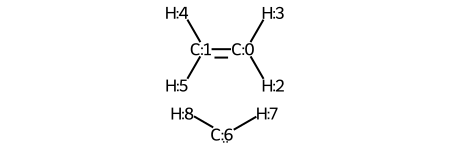

Reactants: [C:0](=[C:1]([H:4])[H:5])([H:2])[H:3].[C:6]([H:7])[H:8]


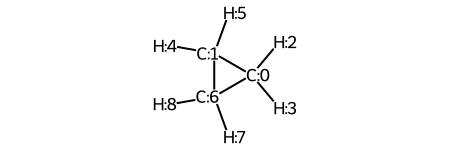

Products: [C:0]1([H:2])([H:3])[C:1]([H:4])([H:5])[C:6]1([H:7])[H:8]


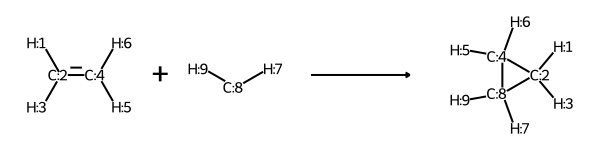

Extracted template: ([#1&+0:1]-[C&+0:2](-[#1&+0:3])=[C&+0:4](-[#1&+0:5])-[#1&+0:6]).([#1&+0:7]-[C&+0:8]-[#1&+0:9])>>([#1&+0:1]-[C&+0:2]1(-[#1&+0:3])-[C&+0:4](-[#1&+0:5])(-[#1&+0:6])-[C&+0:8]-1(-[#1&+0:7])-[#1&+0:9])


1


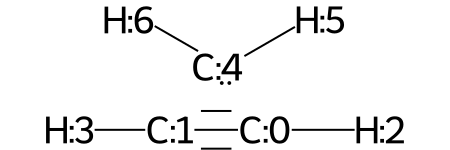

Reactants: [C:0](#[C:1][H:3])[H:2].[C:4]([H:5])[H:6]


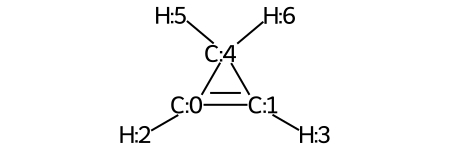

Products: [C:0]1([H:2])=[C:1]([H:3])[C:4]1([H:5])[H:6]


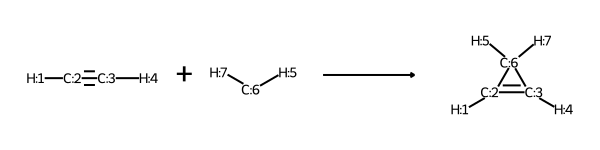

Extracted template: ([#1&+0:1]-[C&+0:2]#[C&+0:3]-[#1&+0:4]).([#1&+0:5]-[C&+0:6]-[#1&+0:7])>>([#1&+0:1]-[C&+0:2]1=[C&+0:3](-[#1&+0:4])-[C&+0:6]-1(-[#1&+0:5])-[#1&+0:7])


2


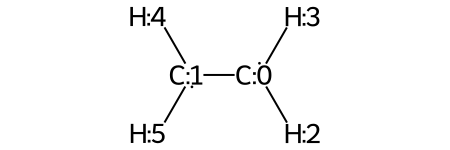

Reactants: [C:0]([C:1]([H:4])[H:5])([H:2])[H:3]


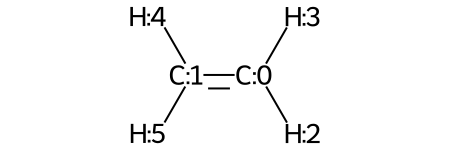

Products: [C:0](=[C:1]([H:4])[H:5])([H:2])[H:3]


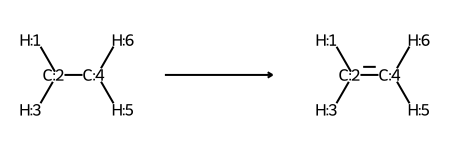

Extracted template: ([#1&+0:1]-[C&+0:2](-[#1&+0:3])-[C&+0:4](-[#1&+0:5])-[#1&+0:6])>>([#1&+0:1]-[C&+0:2](-[#1&+0:3])=[C&+0:4](-[#1&+0:5])-[#1&+0:6])


3


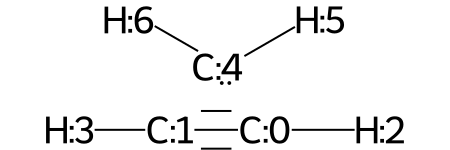

Reactants: [C:0](#[C:1][H:3])[H:2].[C:4]([H:5])[H:6]


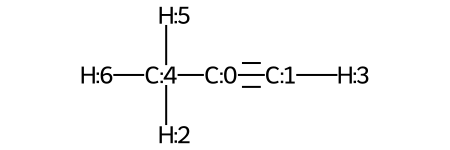

Products: [C:0](#[C:1][H:3])[C:4]([H:2])([H:5])[H:6]


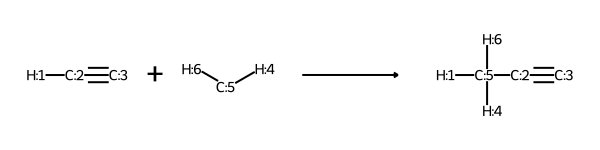

Extracted template: ([#1&+0:1]-[C&+0:2]#[C:3]).([#1&+0:4]-[C&+0:5]-[#1&+0:6])>>([#1&+0:1]-[C&+0:5](-[#1&+0:4])(-[#1&+0:6])-[C&+0:2]#[C:3])


4


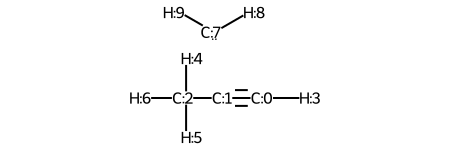

Reactants: [C:0](#[C:1][C:2]([H:4])([H:5])[H:6])[H:3].[C:7]([H:8])[H:9]


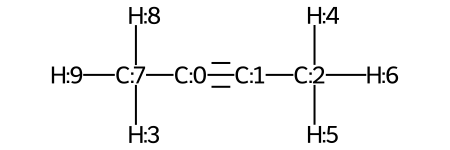

Products: [C:0](#[C:1][C:2]([H:4])([H:5])[H:6])[C:7]([H:3])([H:8])[H:9]


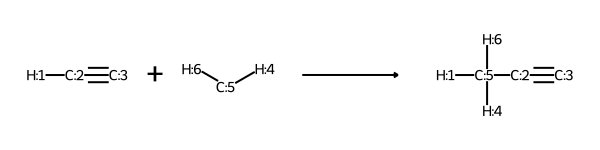

Extracted template: ([#1&+0:1]-[C&+0:2]#[C:3]).([#1&+0:4]-[C&+0:5]-[#1&+0:6])>>([#1&+0:1]-[C&+0:5](-[#1&+0:4])(-[#1&+0:6])-[C&+0:2]#[C:3])


5


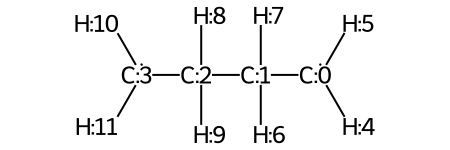

Reactants: [C:0]([C:1]([C:2]([C:3]([H:10])[H:11])([H:8])[H:9])([H:6])[H:7])([H:4])[H:5]


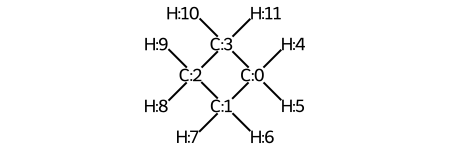

Products: [C:0]1([H:4])([H:5])[C:1]([H:6])([H:7])[C:2]([H:8])([H:9])[C:3]1([H:10])[H:11]


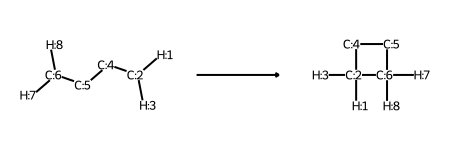

Extracted template: ([#1&+0:1]-[C&+0:2](-[#1&+0:3])-[C:4]-[C:5]-[C&+0:6](-[#1&+0:7])-[#1&+0:8])>>([#1&+0:1]-[C&+0:2]1(-[#1&+0:3])-[C:4]-[C:5]-[C&+0:6]-1(-[#1&+0:7])-[#1&+0:8])


6


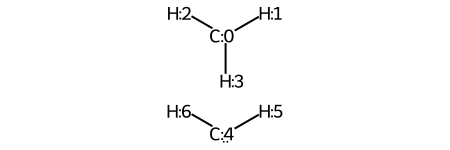

Reactants: [C:0]([H:1])([H:2])[H:3].[C:4]([H:5])[H:6]


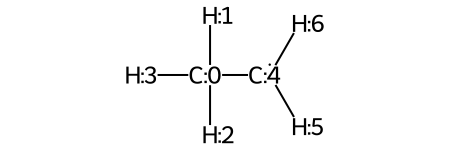

Products: [H:3][C:0]([H:1])([H:2])[C:4]([H:5])[H:6]


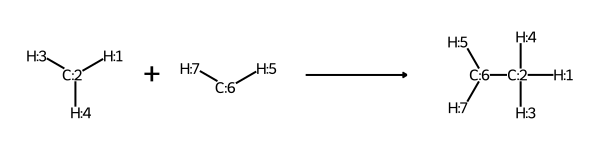

Extracted template: ([#1&+0:1]-[C&+0:2](-[#1&+0:3])-[#1&+0:4]).([#1&+0:5]-[C&+0:6]-[#1&+0:7])>>([#1&+0:1]-[C&+0:2](-[#1&+0:3])(-[#1&+0:4])-[C&+0:6](-[#1&+0:5])-[#1&+0:7])


7


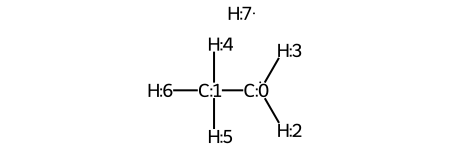

Reactants: [C:0]([C:1]([H:4])([H:5])[H:6])([H:2])[H:3].[H:7]


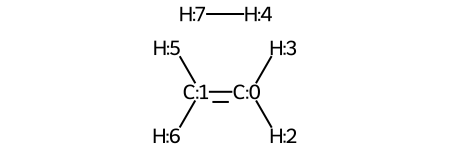

Products: [C:0](=[C:1]([H:5])[H:6])([H:2])[H:3].[H:4][H:7]


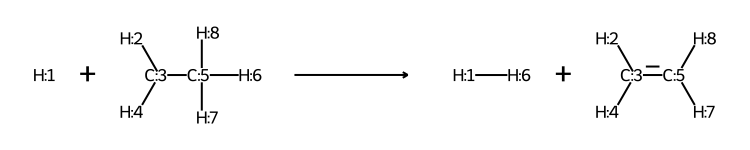

Extracted template: ([#1&+0:1]).([#1&+0:2]-[C&+0:3](-[#1&+0:4])-[C&+0:5](-[#1&+0:6])(-[#1&+0:7])-[#1&+0:8])>>([#1&+0:6]-[#1&+0:1]).([#1&+0:2]-[C&+0:3](-[#1&+0:4])=[C&+0:5](-[#1&+0:7])-[#1&+0:8])


8


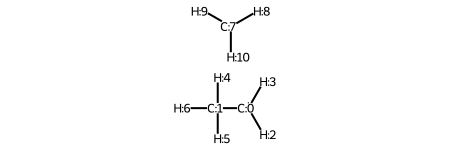

Reactants: [C:0]([C:1]([H:4])([H:5])[H:6])([H:2])[H:3].[C:7]([H:8])([H:9])[H:10]


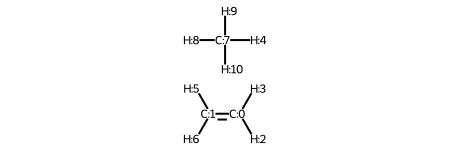

Products: [C:0](=[C:1]([H:5])[H:6])([H:2])[H:3].[H:4][C:7]([H:8])([H:9])[H:10]


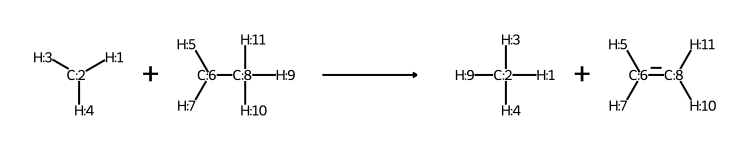

Extracted template: ([#1&+0:1]-[C&+0:2](-[#1&+0:3])-[#1&+0:4]).([#1&+0:5]-[C&+0:6](-[#1&+0:7])-[C&+0:8](-[#1&+0:9])(-[#1&+0:10])-[#1&+0:11])>>([#1&+0:1]-[C&+0:2](-[#1&+0:9])(-[#1&+0:3])-[#1&+0:4]).([#1&+0:5]-[C&+0:6](-[#1&+0:7])=[C&+0:8](-[#1&+0:10])-[#1&+0:11])


9


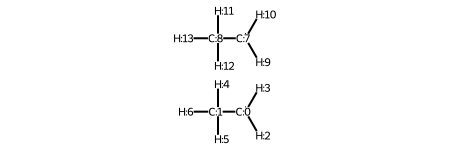

Reactants: [C:0]([C:1]([H:4])([H:5])[H:6])([H:2])[H:3].[C:7]([C:8]([H:11])([H:12])[H:13])([H:9])[H:10]


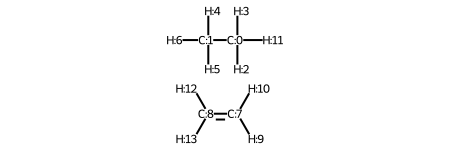

Products: [C:0]([C:1]([H:4])([H:5])[H:6])([H:2])([H:3])[H:11].[C:7](=[C:8]([H:12])[H:13])([H:9])[H:10]


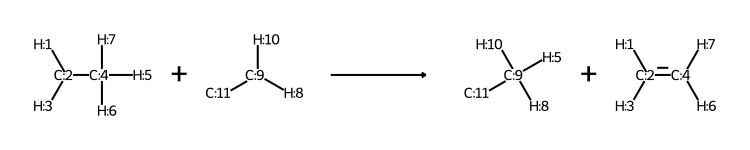

Extracted template: ([#1&+0:1]-[C&+0:2](-[#1&+0:3])-[C&+0:4](-[#1&+0:5])(-[#1&+0:6])-[#1&+0:7]).([#1&+0:8]-[C&+0:9](-[#1&+0:10])-[C:11])>>([#1&+0:5]-[C&+0:9](-[#1&+0:8])(-[#1&+0:10])-[C:11]).([#1&+0:1]-[C&+0:2](-[#1&+0:3])=[C&+0:4](-[#1&+0:6])-[#1&+0:7])


10


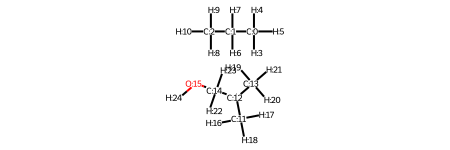

Reactants: [C:0]([C:1]([C:2]([H:8])([H:9])[H:10])([H:6])[H:7])([H:3])([H:4])[H:5].[C:11]([C:12]([C:13]([H:19])([H:20])[H:21])[C:14]([O:15][H:24])([H:22])[H:23])([H:16])([H:17])[H:18]


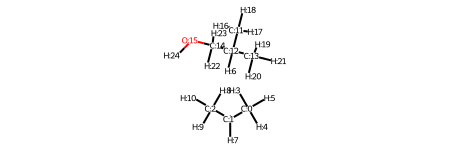

Products: [C:0]([C:1]([C:2]([H:8])([H:9])[H:10])[H:7])([H:3])([H:4])[H:5].[H:6][C:12]([C:11]([H:16])([H:17])[H:18])([C:13]([H:19])([H:20])[H:21])[C:14]([O:15][H:24])([H:22])[H:23]


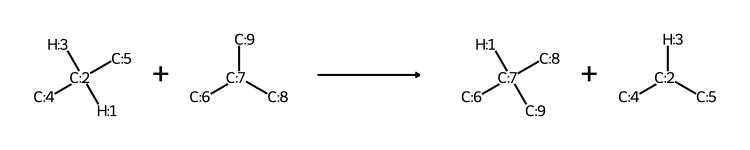

Extracted template: ([#1&+0:1]-[C&+0:2](-[#1&+0:3])(-[C:4])-[C:5]).([C:6]-[C&+0:7](-[C:8])-[C:9])>>([#1&+0:1]-[C&+0:7](-[C:6])(-[C:8])-[C:9]).([#1&+0:3]-[C&+0:2](-[C:4])-[C:5])


11


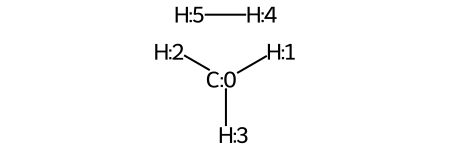

Reactants: [C:0]([H:1])([H:2])[H:3].[H:4][H:5]


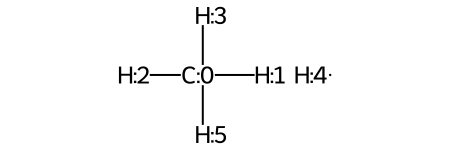

Products: [C:0]([H:1])([H:2])([H:3])[H:5].[H:4]


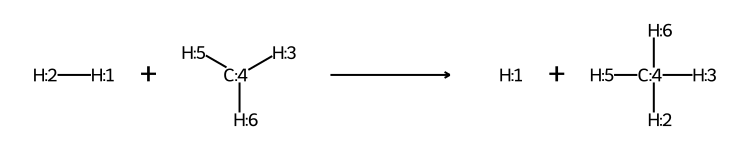

Extracted template: ([#1&+0:1]-[#1&+0:2]).([#1&+0:3]-[C&+0:4](-[#1&+0:5])-[#1&+0:6])>>([#1&+0:1]).([#1&+0:3]-[C&+0:4](-[#1&+0:5])(-[#1&+0:6])-[#1&+0:2])


12


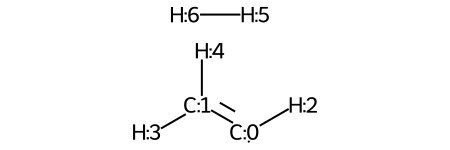

Reactants: [C:0](=[C:1]([H:3])[H:4])[H:2].[H:5][H:6]


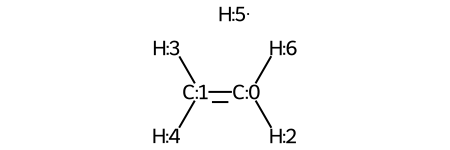

Products: [C:0](=[C:1]([H:3])[H:4])([H:2])[H:6].[H:5]


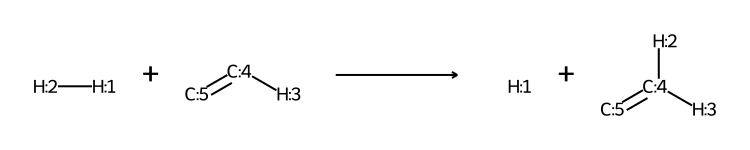

Extracted template: ([#1&+0:1]-[#1&+0:2]).([#1&+0:3]-[C&+0:4]=[C:5])>>([#1&+0:1]).([#1&+0:3]-[C&+0:4](-[#1&+0:2])=[C:5])


13


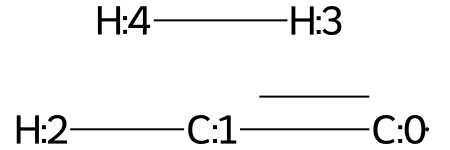

Reactants: [C:0]#[C:1][H:2].[H:3][H:4]


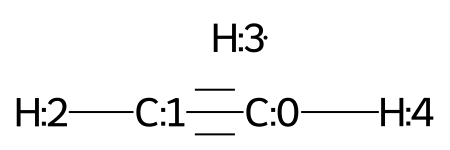

Products: [C:0](#[C:1][H:2])[H:4].[H:3]


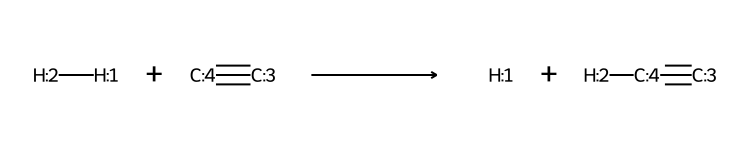

Extracted template: ([#1&+0:1]-[#1&+0:2]).([C:3]#[C&+0:4])>>([#1&+0:1]).([#1&+0:2]-[C&+0:4]#[C:3])


14


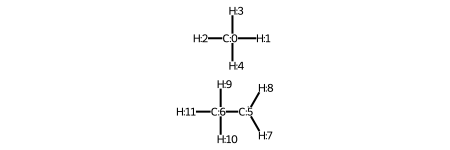

Reactants: [C:0]([H:1])([H:2])([H:3])[H:4].[C:5]([C:6]([H:9])([H:10])[H:11])([H:7])[H:8]


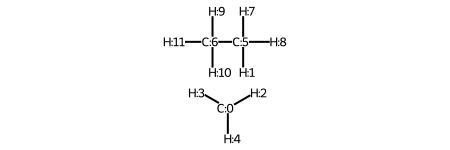

Products: [C:0]([H:2])([H:3])[H:4].[H:1][C:5]([C:6]([H:9])([H:10])[H:11])([H:7])[H:8]


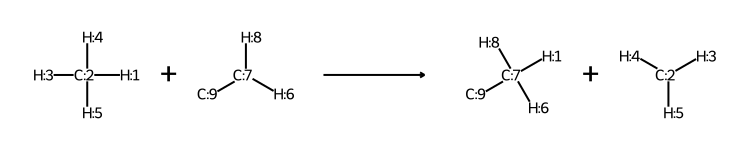

Extracted template: ([#1&+0:1]-[C&+0:2](-[#1&+0:3])(-[#1&+0:4])-[#1&+0:5]).([#1&+0:6]-[C&+0:7](-[#1&+0:8])-[C:9])>>([#1&+0:1]-[C&+0:7](-[#1&+0:6])(-[#1&+0:8])-[C:9]).([#1&+0:3]-[C&+0:2](-[#1&+0:4])-[#1&+0:5])


15


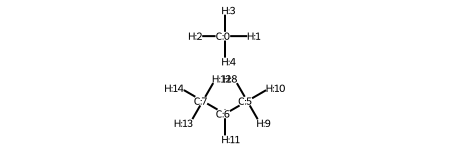

Reactants: [C:0]([H:1])([H:2])([H:3])[H:4].[C:5]([C:6]([C:7]([H:12])([H:13])[H:14])[H:11])([H:8])([H:9])[H:10]


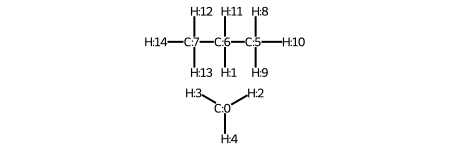

Products: [C:0]([H:2])([H:3])[H:4].[H:1][C:6]([C:5]([H:8])([H:9])[H:10])([C:7]([H:12])([H:13])[H:14])[H:11]


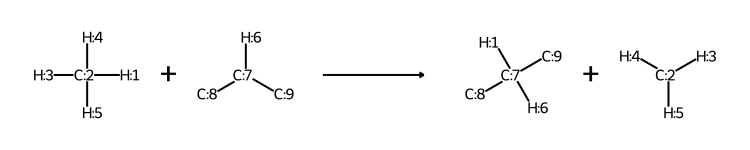

Extracted template: ([#1&+0:1]-[C&+0:2](-[#1&+0:3])(-[#1&+0:4])-[#1&+0:5]).([#1&+0:6]-[C&+0:7](-[C:8])-[C:9])>>([#1&+0:6]-[C&+0:7](-[#1&+0:1])(-[C:8])-[C:9]).([#1&+0:3]-[C&+0:2](-[#1&+0:4])-[#1&+0:5])


16


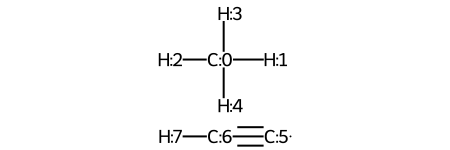

Reactants: [C:0]([H:1])([H:2])([H:3])[H:4].[C:5]#[C:6][H:7]


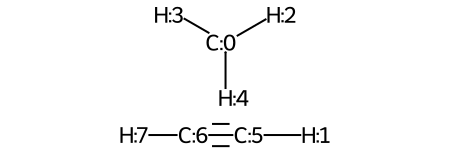

Products: [C:0]([H:2])([H:3])[H:4].[H:1][C:5]#[C:6][H:7]


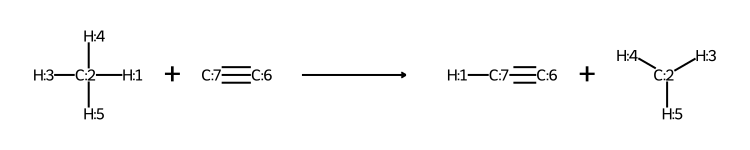

Extracted template: ([#1&+0:1]-[C&+0:2](-[#1&+0:3])(-[#1&+0:4])-[#1&+0:5]).([C:6]#[C&+0:7])>>([#1&+0:1]-[C&+0:7]#[C:6]).([#1&+0:3]-[C&+0:2](-[#1&+0:4])-[#1&+0:5])


17


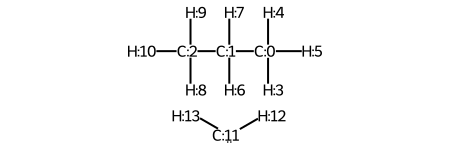

Reactants: [C:0]([C:1]([C:2]([H:8])([H:9])[H:10])([H:6])[H:7])([H:3])([H:4])[H:5].[C:11]([H:12])[H:13]


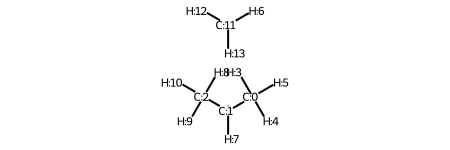

Products: [C:0]([C:1]([C:2]([H:8])([H:9])[H:10])[H:7])([H:3])([H:4])[H:5].[H:6][C:11]([H:12])[H:13]


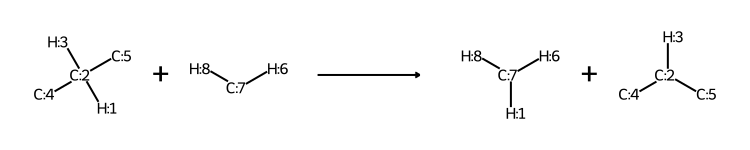

Extracted template: ([#1&+0:1]-[C&+0:2](-[#1&+0:3])(-[C:4])-[C:5]).([#1&+0:6]-[C&+0:7]-[#1&+0:8])>>([#1&+0:6]-[C&+0:7](-[#1&+0:8])-[#1&+0:1]).([#1&+0:3]-[C&+0:2](-[C:4])-[C:5])


18


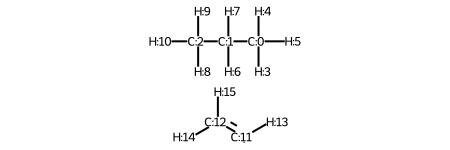

Reactants: [C:0]([C:1]([C:2]([H:8])([H:9])[H:10])([H:6])[H:7])([H:3])([H:4])[H:5].[C:11](=[C:12]([H:14])[H:15])[H:13]


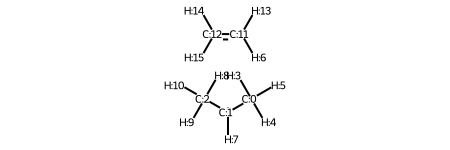

Products: [C:0]([C:1]([C:2]([H:8])([H:9])[H:10])[H:7])([H:3])([H:4])[H:5].[H:6][C:11](=[C:12]([H:14])[H:15])[H:13]


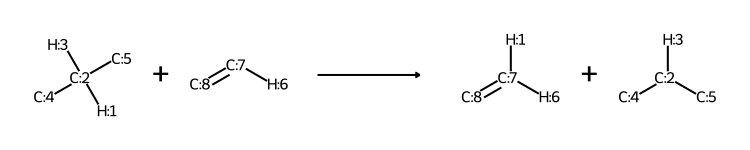

Extracted template: ([#1&+0:1]-[C&+0:2](-[#1&+0:3])(-[C:4])-[C:5]).([#1&+0:6]-[C&+0:7]=[C:8])>>([#1&+0:6]-[C&+0:7](-[#1&+0:1])=[C:8]).([#1&+0:3]-[C&+0:2](-[C:4])-[C:5])


19


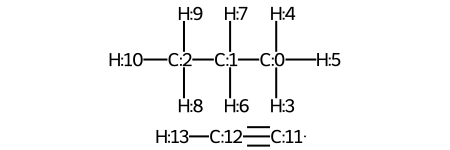

Reactants: [C:0]([C:1]([C:2]([H:8])([H:9])[H:10])([H:6])[H:7])([H:3])([H:4])[H:5].[C:11]#[C:12][H:13]


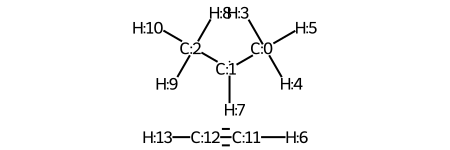

Products: [C:0]([C:1]([C:2]([H:8])([H:9])[H:10])[H:7])([H:3])([H:4])[H:5].[H:6][C:11]#[C:12][H:13]


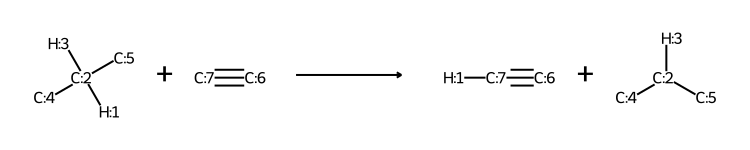

Extracted template: ([#1&+0:1]-[C&+0:2](-[#1&+0:3])(-[C:4])-[C:5]).([C:6]#[C&+0:7])>>([#1&+0:1]-[C&+0:7]#[C:6]).([#1&+0:3]-[C&+0:2](-[C:4])-[C:5])


20


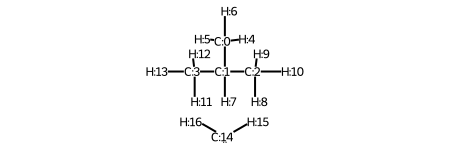

Reactants: [C:0]([C:1]([C:2]([H:8])([H:9])[H:10])([C:3]([H:11])([H:12])[H:13])[H:7])([H:4])([H:5])[H:6].[C:14]([H:15])[H:16]


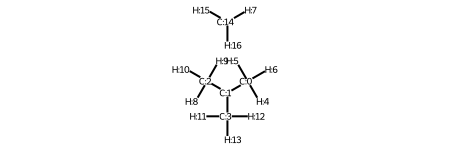

Products: [C:0]([C:1]([C:2]([H:8])([H:9])[H:10])[C:3]([H:11])([H:12])[H:13])([H:4])([H:5])[H:6].[H:7][C:14]([H:15])[H:16]


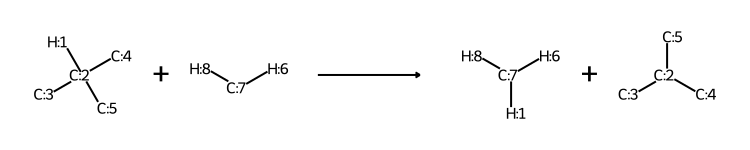

Extracted template: ([#1&+0:1]-[C&+0:2](-[C:3])(-[C:4])-[C:5]).([#1&+0:6]-[C&+0:7]-[#1&+0:8])>>([#1&+0:6]-[C&+0:7](-[#1&+0:8])-[#1&+0:1]).([C:3]-[C&+0:2](-[C:4])-[C:5])


21


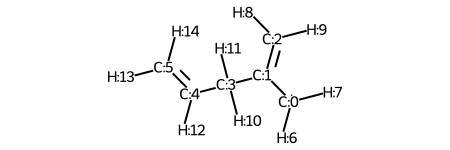

Reactants: [C:0]([C:1](=[C:2]([H:8])[H:9])[C:3]([C:4](=[C:5]([H:13])[H:14])[H:12])([H:10])[H:11])([H:6])[H:7]


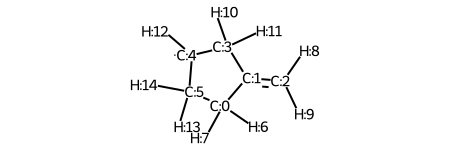

Products: [C:0]1([H:6])([H:7])[C:1](=[C:2]([H:8])[H:9])[C:3]([H:10])([H:11])[C:4]([H:12])[C:5]1([H:13])[H:14]


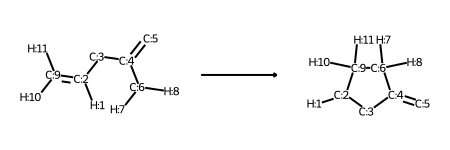

Extracted template: ([#1&+0:1]-[C&+0:2](-[C:3]-[C:4](=[C:5])-[C&+0:6](-[#1&+0:7])-[#1&+0:8])=[C&+0:9](-[#1&+0:10])-[#1&+0:11])>>([#1&+0:1]-[C&+0:2]1-[C:3]-[C:4](=[C:5])-[C&+0:6](-[#1&+0:7])(-[#1&+0:8])-[C&+0:9]-1(-[#1&+0:10])-[#1&+0:11])


22


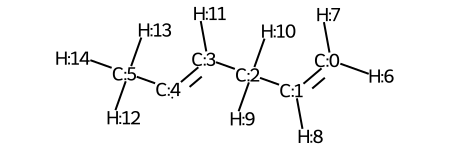

Reactants: [C:0](=[C:1]([C:2]([C:3](=[C:4][C:5]([H:12])([H:13])[H:14])[H:11])([H:9])[H:10])[H:8])([H:6])[H:7]


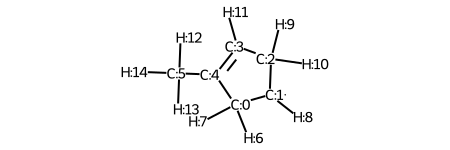

Products: [C:0]1([H:6])([H:7])[C:1]([H:8])[C:2]([H:9])([H:10])[C:3]([H:11])=[C:4]1[C:5]([H:12])([H:13])[H:14]


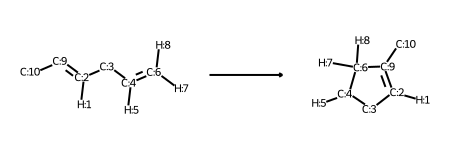

Extracted template: ([#1&+0:1]-[C:2](-[C:3]-[C&+0:4](-[#1&+0:5])=[C&+0:6](-[#1&+0:7])-[#1&+0:8])=[C&+0:9]-[C:10])>>([#1&+0:1]-[C:2]1=[C&+0:9](-[C:10])-[C&+0:6](-[#1&+0:7])(-[#1&+0:8])-[C&+0:4](-[#1&+0:5])-[C:3]-1)


23


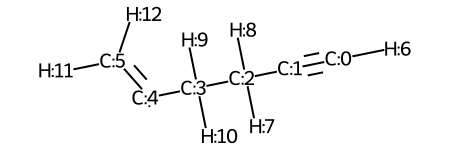

Reactants: [C:0](#[C:1][C:2]([C:3]([C:4]=[C:5]([H:11])[H:12])([H:9])[H:10])([H:7])[H:8])[H:6]


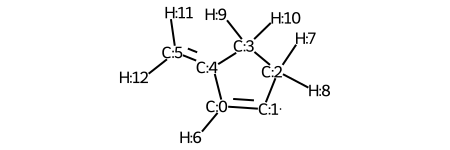

Products: [C:0]1([H:6])=[C:1][C:2]([H:7])([H:8])[C:3]([H:9])([H:10])[C:4]1=[C:5]([H:11])[H:12]


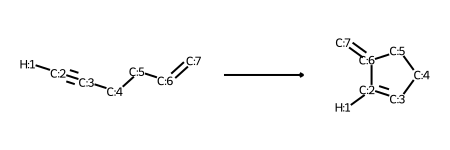

Extracted template: ([#1&+0:1]-[C&+0:2]#[C&+0:3]-[C:4]-[C:5]-[C&+0:6]=[C:7])>>([#1&+0:1]-[C&+0:2]1=[C&+0:3]-[C:4]-[C:5]-[C&+0:6]-1=[C:7])


24


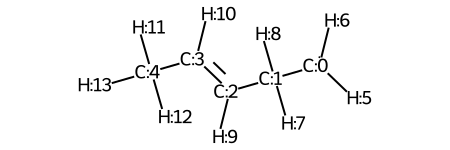

Reactants: [C:0]([C:1]([C:2](=[C:3]([C:4]([H:11])([H:12])[H:13])[H:10])[H:9])([H:7])[H:8])([H:5])[H:6]


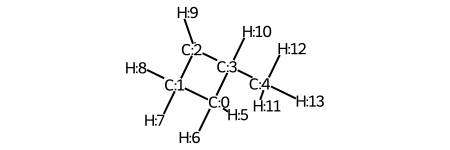

Products: [C:0]1([H:5])([H:6])[C:1]([H:7])([H:8])[C:2]([H:9])[C:3]1([C:4]([H:11])([H:12])[H:13])[H:10]


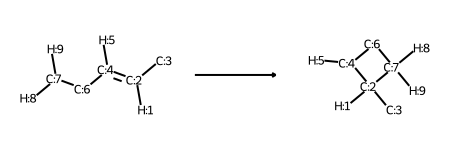

Extracted template: ([#1&+0:1]-[C&+0:2](-[C:3])=[C&+0:4](-[#1&+0:5])-[C:6]-[C&+0:7](-[#1&+0:8])-[#1&+0:9])>>([#1&+0:1]-[C&+0:2]1(-[C:3])-[C&+0:4](-[#1&+0:5])-[C:6]-[C&+0:7]-1(-[#1&+0:8])-[#1&+0:9])


25


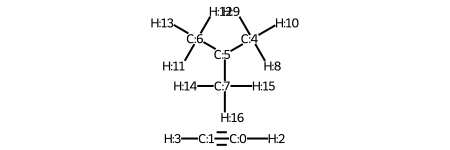

Reactants: [C:0](#[C:1][H:3])[H:2].[C:4]([C:5]([C:6]([H:11])([H:12])[H:13])[C:7]([H:14])([H:15])[H:16])([H:8])([H:9])[H:10]


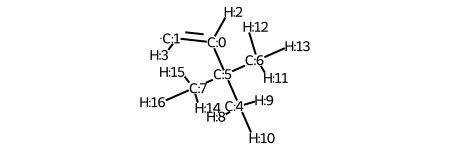

Products: [C:0](=[C:1][H:3])([H:2])[C:5]([C:4]([H:8])([H:9])[H:10])([C:6]([H:11])([H:12])[H:13])[C:7]([H:14])([H:15])[H:16]


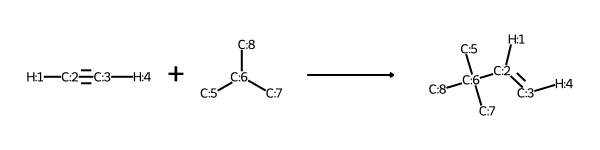

Extracted template: ([#1&+0:1]-[C&+0:2]#[C&+0:3]-[#1&+0:4]).([C:5]-[C&+0:6](-[C:7])-[C:8])>>([#1&+0:1]-[C&+0:2](=[C&+0:3]-[#1&+0:4])-[C&+0:6](-[C:5])(-[C:7])-[C:8])


26


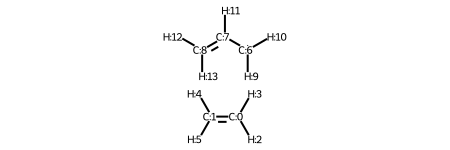

Reactants: [C:0](=[C:1]([H:4])[H:5])([H:2])[H:3].[C:6]([C:7](=[C:8]([H:12])[H:13])[H:11])([H:9])[H:10]


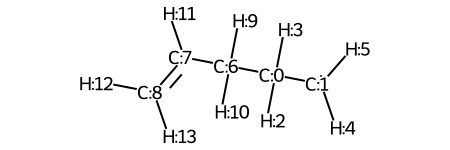

Products: [C:0]([C:1]([H:4])[H:5])([H:2])([H:3])[C:6]([C:7](=[C:8]([H:12])[H:13])[H:11])([H:9])[H:10]


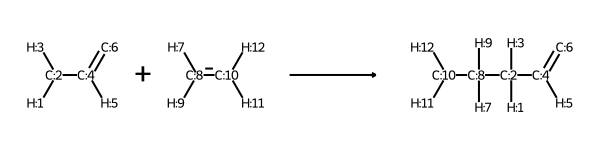

Extracted template: ([#1&+0:1]-[C&+0:2](-[#1&+0:3])-[C:4](-[#1&+0:5])=[C:6]).([#1&+0:7]-[C&+0:8](-[#1&+0:9])=[C&+0:10](-[#1&+0:11])-[#1&+0:12])>>([#1&+0:1]-[C&+0:2](-[#1&+0:3])(-[C:4](-[#1&+0:5])=[C:6])-[C&+0:8](-[#1&+0:7])(-[#1&+0:9])-[C&+0:10](-[#1&+0:11])-[#1&+0:12])


27


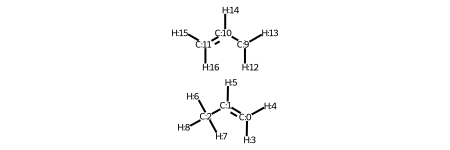

Reactants: [C:0](=[C:1]([C:2]([H:6])([H:7])[H:8])[H:5])([H:3])[H:4].[C:9]([C:10](=[C:11]([H:15])[H:16])[H:14])([H:12])[H:13]


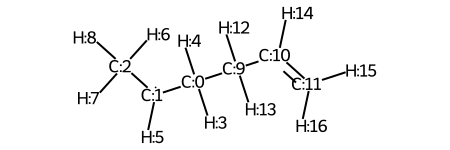

Products: [C:0]([C:1]([C:2]([H:6])([H:7])[H:8])[H:5])([H:3])([H:4])[C:9]([C:10](=[C:11]([H:15])[H:16])[H:14])([H:12])[H:13]


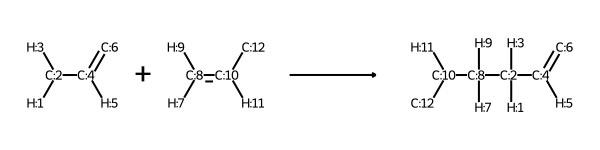

Extracted template: ([#1&+0:1]-[C&+0:2](-[#1&+0:3])-[C:4](-[#1&+0:5])=[C:6]).([#1&+0:7]-[C&+0:8](-[#1&+0:9])=[C&+0:10](-[#1&+0:11])-[C:12])>>([#1&+0:1]-[C&+0:2](-[#1&+0:3])(-[C:4](-[#1&+0:5])=[C:6])-[C&+0:8](-[#1&+0:7])(-[#1&+0:9])-[C&+0:10](-[#1&+0:11])-[C:12])


28


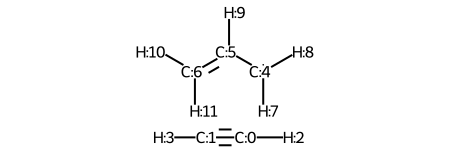

Reactants: [C:0](#[C:1][H:3])[H:2].[C:4]([C:5](=[C:6]([H:10])[H:11])[H:9])([H:7])[H:8]


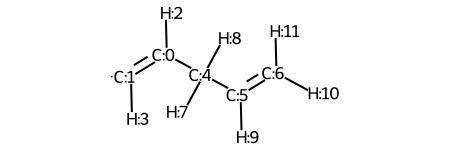

Products: [C:0](=[C:1][H:3])([H:2])[C:4]([C:5](=[C:6]([H:10])[H:11])[H:9])([H:7])[H:8]


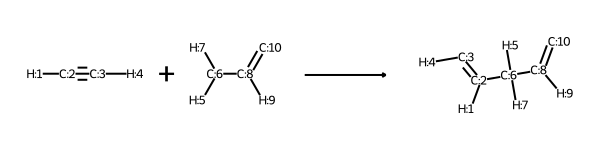

Extracted template: ([#1&+0:1]-[C&+0:2]#[C&+0:3]-[#1&+0:4]).([#1&+0:5]-[C&+0:6](-[#1&+0:7])-[C:8](-[#1&+0:9])=[C:10])>>([#1&+0:1]-[C&+0:2](=[C&+0:3]-[#1&+0:4])-[C&+0:6](-[#1&+0:5])(-[#1&+0:7])-[C:8](-[#1&+0:9])=[C:10])


29


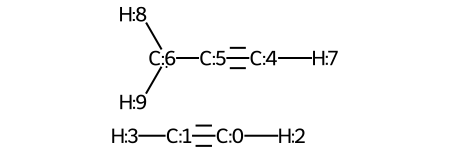

Reactants: [C:0](#[C:1][H:3])[H:2].[C:4](#[C:5][C:6]([H:8])[H:9])[H:7]


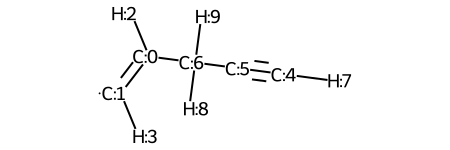

Products: [C:0](=[C:1][H:3])([H:2])[C:6]([C:5]#[C:4][H:7])([H:8])[H:9]


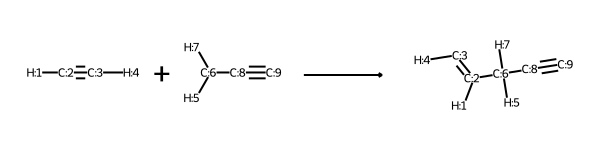

Extracted template: ([#1&+0:1]-[C&+0:2]#[C&+0:3]-[#1&+0:4]).([#1&+0:5]-[C&+0:6](-[#1&+0:7])-[C:8]#[C:9])>>([#1&+0:1]-[C&+0:2](=[C&+0:3]-[#1&+0:4])-[C&+0:6](-[#1&+0:5])(-[#1&+0:7])-[C:8]#[C:9])


30


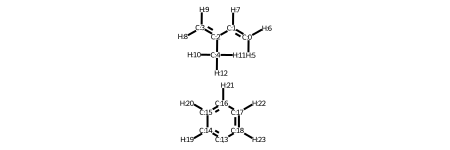

Reactants: [C:0](=[C:1]([C:2](=[C:3]([H:8])[H:9])[C:4]([H:10])([H:11])[H:12])[H:7])([H:5])[H:6].[c:13]1[c:14]([H:19])[c:15]([H:20])[c:16]([H:21])[c:17]([H:22])[c:18]1[H:23]


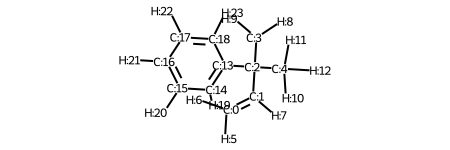

Products: [C:0](=[C:1]([C:2]([C:3]([H:8])[H:9])([C:4]([H:10])([H:11])[H:12])[c:13]1[c:14]([H:19])[c:15]([H:20])[c:16]([H:21])[c:17]([H:22])[c:18]1[H:23])[H:7])([H:5])[H:6]


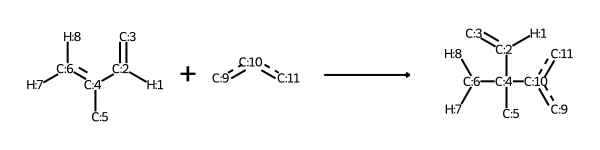

Extracted template: ([#1&+0:1]-[C:2](=[C:3])-[C&+0:4](-[C:5])=[C&+0:6](-[#1&+0:7])-[#1&+0:8]).([c:9]:[c&+0:10]:[c:11])>>([#1&+0:1]-[C:2](=[C:3])-[C&+0:4](-[C:5])(-[C&+0:6](-[#1&+0:7])-[#1&+0:8])-[c&+0:10](:[c:9]):[c:11])


31


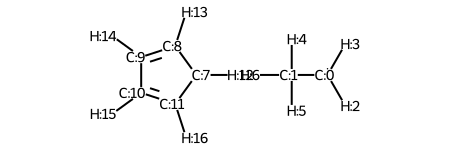

Reactants: [C:0]([C:1]([H:4])([H:5])[H:6])([H:2])[H:3].[C:7]1([H:12])[C:8]([H:13])=[C:9]([H:14])[C:10]([H:15])=[C:11]1[H:16]


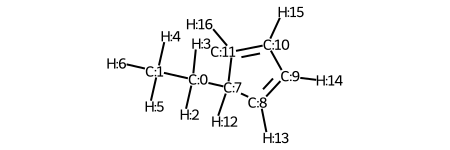

Products: [C:0]([C:1]([H:4])([H:5])[H:6])([H:2])([H:3])[C:7]1([H:12])[C:8]([H:13])=[C:9]([H:14])[C:10]([H:15])=[C:11]1[H:16]


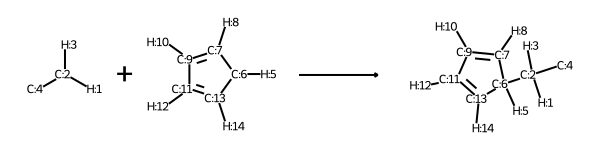

Extracted template: ([#1&+0:1]-[C&+0:2](-[#1&+0:3])-[C:4]).([#1&+0:5]-[C&+0:6]1-[C:7](-[#1&+0:8])=[C:9](-[#1&+0:10])-[C:11](-[#1&+0:12])=[C:13]-1-[#1&+0:14])>>([#1&+0:5]-[C&+0:6]1(-[C&+0:2](-[#1&+0:1])(-[#1&+0:3])-[C:4])-[C:7](-[#1&+0:8])=[C:9](-[#1&+0:10])-[C:11](-[#1&+0:12])=[C:13]-1-[#1&+0:14])


32


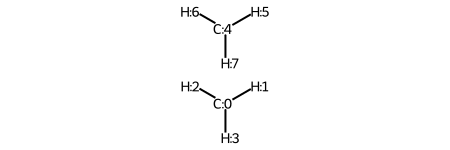

Reactants: [C:0]([H:1])([H:2])[H:3].[C:4]([H:5])([H:6])[H:7]


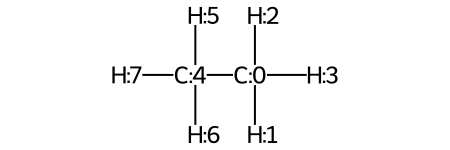

Products: [C:0]([H:1])([H:2])([H:3])[C:4]([H:5])([H:6])[H:7]


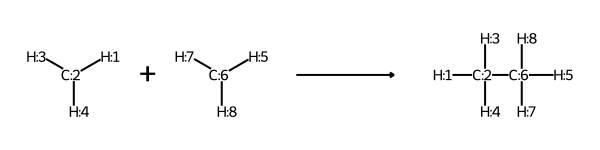

Extracted template: ([#1&+0:1]-[C&+0:2](-[#1&+0:3])-[#1&+0:4]).([#1&+0:5]-[C&+0:6](-[#1&+0:7])-[#1&+0:8])>>([#1&+0:1]-[C&+0:2](-[#1&+0:3])(-[#1&+0:4])-[C&+0:6](-[#1&+0:5])(-[#1&+0:7])-[#1&+0:8])


33


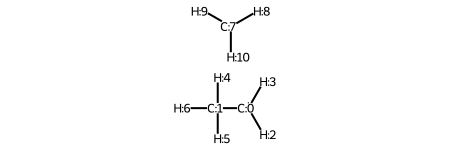

Reactants: [C:0]([C:1]([H:4])([H:5])[H:6])([H:2])[H:3].[C:7]([H:8])([H:9])[H:10]


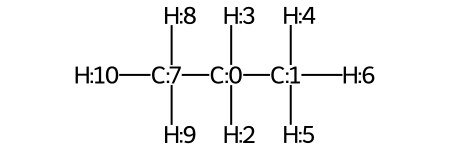

Products: [C:0]([C:1]([H:4])([H:5])[H:6])([H:2])([H:3])[C:7]([H:8])([H:9])[H:10]


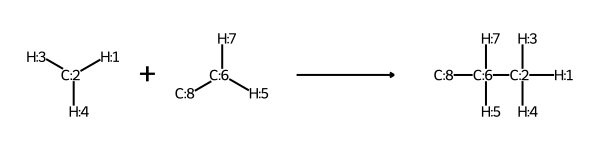

Extracted template: ([#1&+0:1]-[C&+0:2](-[#1&+0:3])-[#1&+0:4]).([#1&+0:5]-[C&+0:6](-[#1&+0:7])-[C:8])>>([#1&+0:1]-[C&+0:2](-[#1&+0:3])(-[#1&+0:4])-[C&+0:6](-[#1&+0:5])(-[#1&+0:7])-[C:8])


34


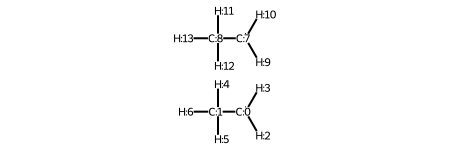

Reactants: [C:0]([C:1]([H:4])([H:5])[H:6])([H:2])[H:3].[C:7]([C:8]([H:11])([H:12])[H:13])([H:9])[H:10]


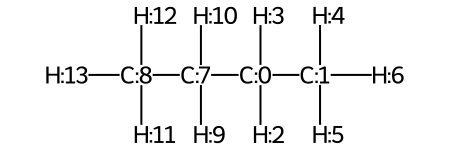

Products: [C:0]([C:1]([H:4])([H:5])[H:6])([H:2])([H:3])[C:7]([C:8]([H:11])([H:12])[H:13])([H:9])[H:10]


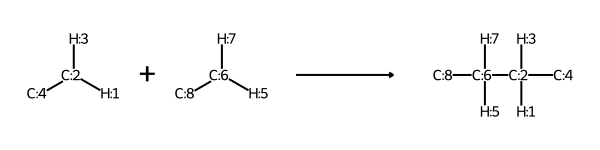

Extracted template: ([#1&+0:1]-[C&+0:2](-[#1&+0:3])-[C:4]).([#1&+0:5]-[C&+0:6](-[#1&+0:7])-[C:8])>>([#1&+0:5]-[C&+0:6](-[#1&+0:7])(-[C:8])-[C&+0:2](-[#1&+0:1])(-[#1&+0:3])-[C:4])


35


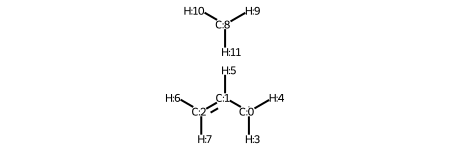

Reactants: [C:0]([C:1](=[C:2]([H:6])[H:7])[H:5])([H:3])[H:4].[C:8]([H:9])([H:10])[H:11]


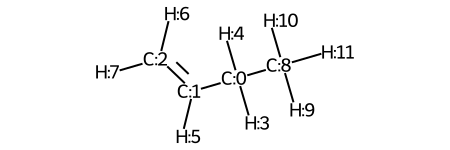

Products: [C:0]([C:1](=[C:2]([H:6])[H:7])[H:5])([H:3])([H:4])[C:8]([H:9])([H:10])[H:11]


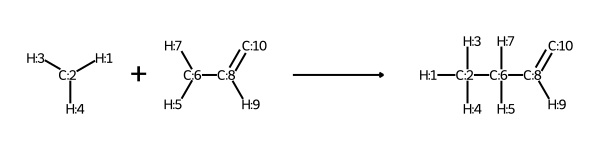

Extracted template: ([#1&+0:1]-[C&+0:2](-[#1&+0:3])-[#1&+0:4]).([#1&+0:5]-[C&+0:6](-[#1&+0:7])-[C:8](-[#1&+0:9])=[C:10])>>([#1&+0:1]-[C&+0:2](-[#1&+0:3])(-[#1&+0:4])-[C&+0:6](-[#1&+0:5])(-[#1&+0:7])-[C:8](-[#1&+0:9])=[C:10])


36


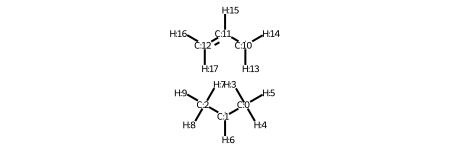

Reactants: [C:0]([C:1]([C:2]([H:7])([H:8])[H:9])[H:6])([H:3])([H:4])[H:5].[C:10]([C:11](=[C:12]([H:16])[H:17])[H:15])([H:13])[H:14]


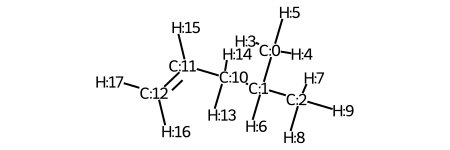

Products: [C:0]([C:1]([C:2]([H:7])([H:8])[H:9])([H:6])[C:10]([C:11](=[C:12]([H:16])[H:17])[H:15])([H:13])[H:14])([H:3])([H:4])[H:5]


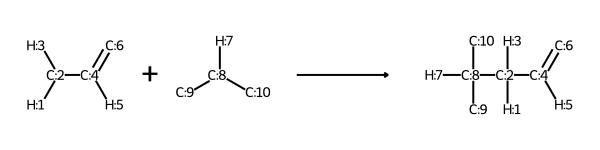

Extracted template: ([#1&+0:1]-[C&+0:2](-[#1&+0:3])-[C:4](-[#1&+0:5])=[C:6]).([#1&+0:7]-[C&+0:8](-[C:9])-[C:10])>>([#1&+0:1]-[C&+0:2](-[#1&+0:3])(-[C:4](-[#1&+0:5])=[C:6])-[C&+0:8](-[#1&+0:7])(-[C:9])-[C:10])


37


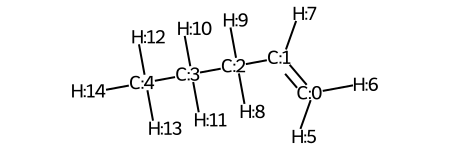

Reactants: [C:0](=[C:1]([C:2]([C:3]([C:4]([H:12])([H:13])[H:14])([H:10])[H:11])([H:8])[H:9])[H:7])([H:5])[H:6]


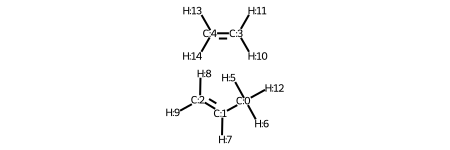

Products: [C:0]([C:1](=[C:2]([H:8])[H:9])[H:7])([H:5])([H:6])[H:12].[C:3](=[C:4]([H:13])[H:14])([H:10])[H:11]


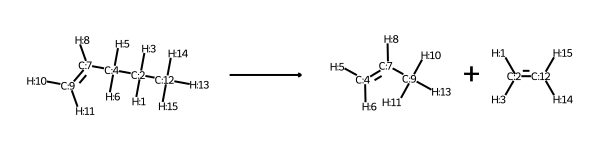

Extracted template: ([#1&+0:1]-[C&+0:2](-[#1&+0:3])(-[C&+0:4](-[#1&+0:5])(-[#1&+0:6])-[C&+0:7](-[#1&+0:8])=[C&+0:9](-[#1&+0:10])-[#1&+0:11])-[C&+0:12](-[#1&+0:13])(-[#1&+0:14])-[#1&+0:15])>>([#1&+0:13]-[C&+0:9](-[#1&+0:10])(-[#1&+0:11])-[C&+0:7](-[#1&+0:8])=[C&+0:4](-[#1&+0:5])-[#1&+0:6]).([#1&+0:1]-[C&+0:2](-[#1&+0:3])=[C&+0:12](-[#1&+0:14])-[#1&+0:15])


38


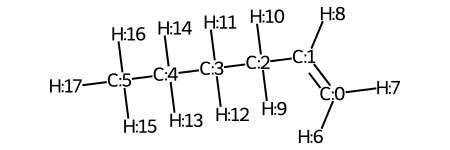

Reactants: [C:0](=[C:1]([C:2]([C:3]([C:4]([C:5]([H:15])([H:16])[H:17])([H:13])[H:14])([H:11])[H:12])([H:9])[H:10])[H:8])([H:6])[H:7]


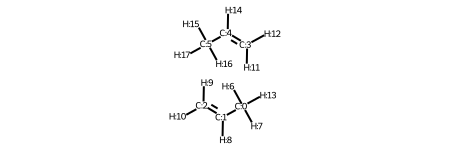

Products: [C:0]([C:1](=[C:2]([H:9])[H:10])[H:8])([H:6])([H:7])[H:13].[C:3](=[C:4]([C:5]([H:15])([H:16])[H:17])[H:14])([H:11])[H:12]


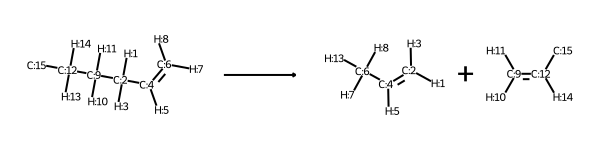

Extracted template: ([#1&+0:1]-[C&+0:2](-[#1&+0:3])(-[C&+0:4](-[#1&+0:5])=[C&+0:6](-[#1&+0:7])-[#1&+0:8])-[C&+0:9](-[#1&+0:10])(-[#1&+0:11])-[C&+0:12](-[#1&+0:13])(-[#1&+0:14])-[C:15])>>([#1&+0:1]-[C&+0:2](-[#1&+0:3])=[C&+0:4](-[#1&+0:5])-[C&+0:6](-[#1&+0:13])(-[#1&+0:7])-[#1&+0:8]).([#1&+0:10]-[C&+0:9](-[#1&+0:11])=[C&+0:12](-[#1&+0:14])-[C:15])


39


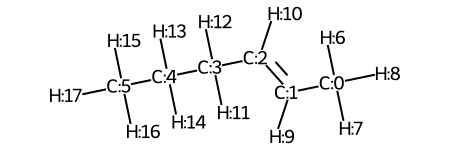

Reactants: [C:0]([C:1](=[C:2]([C:3]([C:4]([C:5]([H:15])([H:16])[H:17])([H:13])[H:14])([H:11])[H:12])[H:10])[H:9])([H:6])([H:7])[H:8]


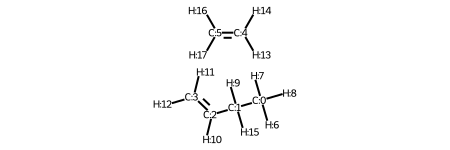

Products: [C:0]([C:1]([C:2](=[C:3]([H:11])[H:12])[H:10])([H:9])[H:15])([H:6])([H:7])[H:8].[C:4](=[C:5]([H:16])[H:17])([H:13])[H:14]


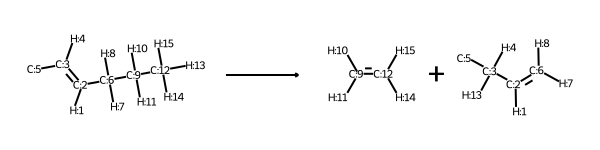

Extracted template: ([#1&+0:1]-[C&+0:2](=[C&+0:3](-[#1&+0:4])-[C:5])-[C&+0:6](-[#1&+0:7])(-[#1&+0:8])-[C&+0:9](-[#1&+0:10])(-[#1&+0:11])-[C&+0:12](-[#1&+0:13])(-[#1&+0:14])-[#1&+0:15])>>([#1&+0:10]-[C&+0:9](-[#1&+0:11])=[C&+0:12](-[#1&+0:14])-[#1&+0:15]).([#1&+0:1]-[C&+0:2](=[C&+0:6](-[#1&+0:7])-[#1&+0:8])-[C&+0:3](-[#1&+0:13])(-[#1&+0:4])-[C:5])


40


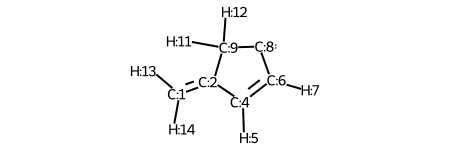

Reactants: [C:1](=[C:2]1[C:4]([H:5])=[C:6]([H:7])[C:8][C:9]1([H:11])[H:12])([H:13])[H:14]


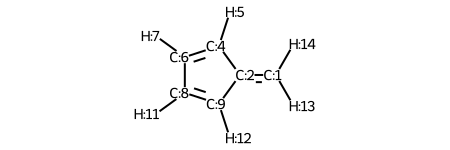

Products: [C:1](=[C:2]1[C:4]([H:5])=[C:6]([H:7])[C:8]([H:11])=[C:9]1[H:12])([H:13])[H:14]


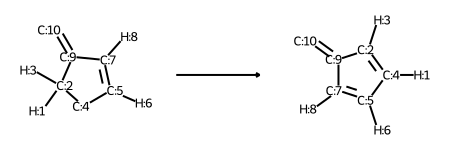

Extracted template: ([#1&+0:1]-[C&+0:2]1(-[#1&+0:3])-[C&+0:4]-[C:5](-[#1&+0:6])=[C:7](-[#1&+0:8])-[C:9]-1=[C:10])>>([#1&+0:1]-[C&+0:4]1=[C&+0:2](-[#1&+0:3])-[C:9](=[C:10])-[C:7](-[#1&+0:8])=[C:5]-1-[#1&+0:6])


41


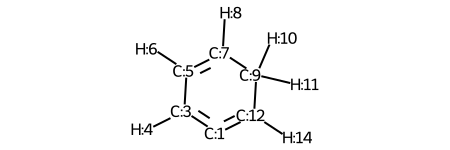

Reactants: [C:1]1=[C:3]([H:4])[C:5]([H:6])=[C:7]([H:8])[C:9]([H:10])([H:11])[C:12]=1[H:14]


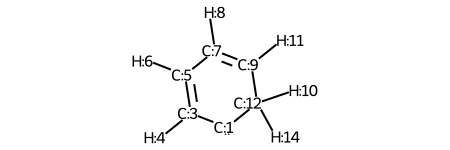

Products: [C:1]1[C:3]([H:4])=[C:5]([H:6])[C:7]([H:8])=[C:9]([H:11])[C:12]1([H:10])[H:14]


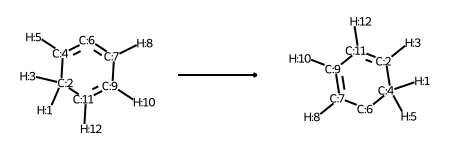

Extracted template: ([#1&+0:1]-[C&+0:2]1(-[#1&+0:3])-[C&+0:4](-[#1&+0:5])=[C&+0:6]=[C&+0:7](-[#1&+0:8])-[C&+0:9](-[#1&+0:10])=[C&+0:11]-1-[#1&+0:12])>>([#1&+0:1]-[C&+0:4]1(-[#1&+0:5])-[C&+0:6]-[C&+0:7](-[#1&+0:8])=[C&+0:9](-[#1&+0:10])-[C&+0:11](-[#1&+0:12])=[C&+0:2]-1-[#1&+0:3])


42


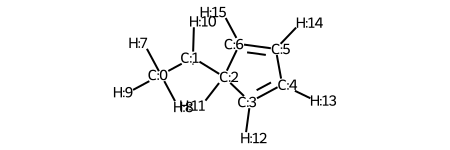

Reactants: [C:0]([C:1]([C:2]1([H:11])[C:3]([H:12])=[C:4]([H:13])[C:5]([H:14])=[C:6]1[H:15])[H:10])([H:7])([H:8])[H:9]


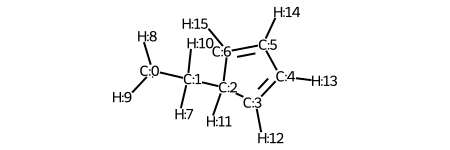

Products: [C:0]([C:1]([C:2]1([H:11])[C:3]([H:12])=[C:4]([H:13])[C:5]([H:14])=[C:6]1[H:15])([H:7])[H:10])([H:8])[H:9]


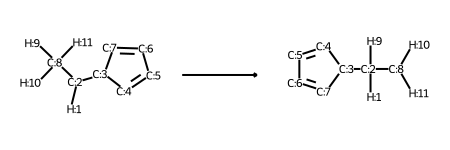

Extracted template: ([#1&+0:1]-[C&+0:2](-[C:3]1-[C:4]=[C:5]-[C:6]=[C:7]-1)-[C&+0:8](-[#1&+0:9])(-[#1&+0:10])-[#1&+0:11])>>([#1&+0:1]-[C&+0:2](-[#1&+0:9])(-[C:3]1-[C:4]=[C:5]-[C:6]=[C:7]-1)-[C&+0:8](-[#1&+0:10])-[#1&+0:11])


43


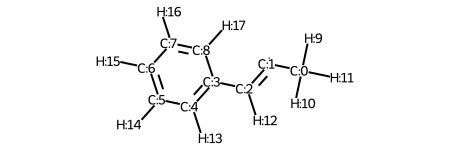

Reactants: [C:0]([C:1]=[C:2]([c:3]1[c:4]([H:13])[c:5]([H:14])[c:6]([H:15])[c:7]([H:16])[c:8]1[H:17])[H:12])([H:9])([H:10])[H:11]


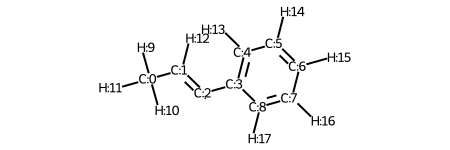

Products: [C:0]([C:1](=[C:2][c:3]1[c:4]([H:13])[c:5]([H:14])[c:6]([H:15])[c:7]([H:16])[c:8]1[H:17])[H:12])([H:9])([H:10])[H:11]


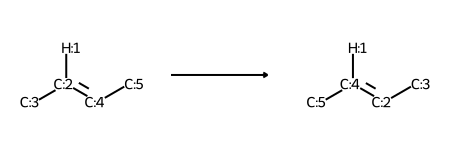

Extracted template: ([#1&+0:1]-[C&+0:2](-[c:3])=[C&+0:4]-[C:5])>>([#1&+0:1]-[C&+0:4](-[C:5])=[C&+0:2]-[c:3])


44


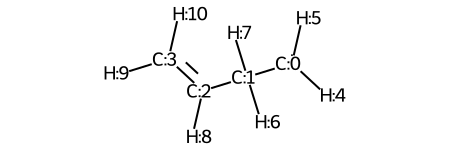

Reactants: [C:0]([C:1]([C:2](=[C:3]([H:9])[H:10])[H:8])([H:6])[H:7])([H:4])[H:5]


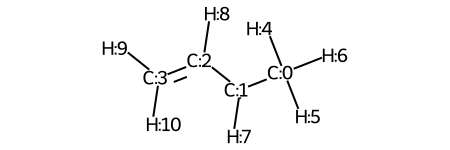

Products: [C:0]([C:1]([C:2](=[C:3]([H:9])[H:10])[H:8])[H:7])([H:4])([H:5])[H:6]


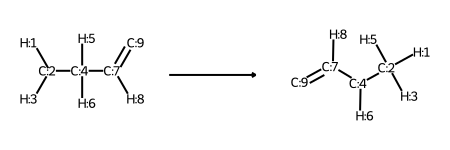

Extracted template: ([#1&+0:1]-[C&+0:2](-[#1&+0:3])-[C&+0:4](-[#1&+0:5])(-[#1&+0:6])-[C:7](-[#1&+0:8])=[C:9])>>([#1&+0:1]-[C&+0:2](-[#1&+0:3])(-[#1&+0:5])-[C&+0:4](-[#1&+0:6])-[C:7](-[#1&+0:8])=[C:9])


45


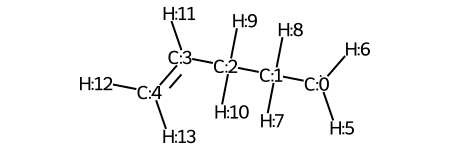

Reactants: [C:0]([C:1]([C:2]([C:3](=[C:4]([H:12])[H:13])[H:11])([H:9])[H:10])([H:7])[H:8])([H:5])[H:6]


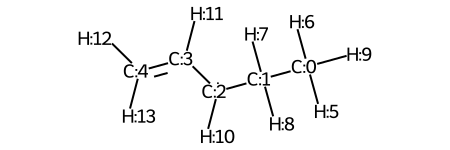

Products: [C:0]([C:1]([C:2]([C:3](=[C:4]([H:12])[H:13])[H:11])[H:10])([H:7])[H:8])([H:5])([H:6])[H:9]


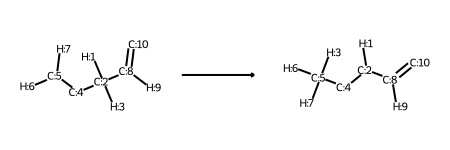

Extracted template: ([#1&+0:1]-[C&+0:2](-[#1&+0:3])(-[C:4]-[C&+0:5](-[#1&+0:6])-[#1&+0:7])-[C:8](-[#1&+0:9])=[C:10])>>([#1&+0:1]-[C&+0:2](-[C:4]-[C&+0:5](-[#1&+0:6])(-[#1&+0:7])-[#1&+0:3])-[C:8](-[#1&+0:9])=[C:10])




In [12]:
for i in range(len(templates)):
    show_k(i)